In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from datetime import datetime

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Read data
import os
print(os.getcwd())

/Users/kunalchakraborty/Downloads/industry_project_HQ


In [3]:
### Load training data
data = pd.read_csv("data/ag_transformed_features.csv")
## Transform date
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

In [4]:
used_features = ["dfy", "infl", "svar", "d/e", "lty", "tms", "tbl", "dfr", "d/p", "d/y", "ltr", "e/p"]
target = ["premium"]

In [5]:
data.set_index("date", inplace=True)

## Step1 : Rolling window training


#### Restrict to using sklearn features

In [6]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [7]:
data.head()

Index      D12      E12       b/m     tbl     AAA     BAA     lty  \
date                                                                            
1959-01-01  55.42  1.75667  2.96333  0.502896  0.0282  0.0412  0.0487  0.0408   
1959-02-01  55.41  1.76333  3.03667  0.494946  0.0270  0.0414  0.0489  0.0402   
1959-03-01  55.44  1.77000  3.11000  0.516860  0.0280  0.0413  0.0485  0.0403   
1959-04-01  57.59  1.77667  3.20667  0.498597  0.0295  0.0423  0.0486  0.0414   
1959-05-01  58.68  1.78333  3.30333  0.483077  0.0284  0.0437  0.0496  0.0417   

                ntis   Rfree  ...  CRSP_SPvwx   returns   premium       d/p  \
date                          ...                                             
1959-01-01  0.027736  0.0021  ...    0.005395       NaN       NaN -3.451521   
1959-02-01  0.027899  0.0019  ...    0.002210  0.002471  0.000571 -3.447556   
1959-03-01  0.024984  0.0022  ...    0.000826  0.003203  0.001003 -3.444322   
1959-04-01  0.024361  0.0020  ...    0.039093  0.041451  0.039451 -3.478608   
1959-05-01  0.025887  0.0022  ...    0.019043  0.021507  0.019307 -3.493617   

                 d/y       e/p       d/e     tms     dfy     dfr  
date                                                              
1959-01-01       NaN -2.928627 -0.522894  0.0126  0.0075  0.0052  
1959-02-01 -3.447736 -2.903999 -0.543557  0.0132  0.0075  0.0009  
1959-03-01 -3.443781 -2.880679 -0.563643  0.0123  0.0072 -0.0100  
1959-04-01 -3.440561 -2.888116 -0.590492  0.0119  0.0063 -0.0055  
1959-05-01 -3.474867 -2.877168 -0.616449  0.0133  0.0059 -0.0109  

[5 rows x 26 columns]

In [8]:
from sklearn.preprocessing import Normalizer

In [9]:
def fix_pred_format(pred_array):
    pred_list = []
    for pred in pred_array:
        pred_list.append(pred[0])
    return pred_list

In [10]:

### Write a function for rolling model training. Use it for predictions as well
def roll_training(Y,X, datelist, model, model_name, train_rolling_length = 60, test_rolling_length = 2):
    """
    Y : Target variable
    X : Training data
    """
    
    predictions = []
    int_start  = 0
    for int_end in range(train_rolling_length, len(datelist), test_rolling_length):
        # Define intervals
        train_interval = datelist[int_start:int_end]
        test_interval = datelist[int_end:int_end+test_rolling_length]
        # Training data
        Yt = Y.loc[train_interval]
        Xt = X.loc[train_interval]
        # Testing data
        Xt_test = X.loc[test_interval]
        # Normalize data
        Xt = Normalizer().fit_transform(Xt)
        Xt_test = Normalizer().transform(Xt_test)
        
        model.fit(Xt,Yt)
        # Perform prediction
        Yt_pred = model.predict(Xt_test)
        if model_name == "reg":
            # Fix prediction format
            Yt_pred = fix_pred_format(Yt_pred)
        df_temp = pd.DataFrame([test_interval, Yt_pred]).T
        df_temp.columns = ["date",model_name]
        predictions.append(df_temp)
        # Update index
        int_start += test_rolling_length
        
    pred_df = pd.concat(predictions)
    return pred_df

In [11]:
data.head()

Index      D12      E12       b/m     tbl     AAA     BAA     lty  \
date                                                                            
1959-01-01  55.42  1.75667  2.96333  0.502896  0.0282  0.0412  0.0487  0.0408   
1959-02-01  55.41  1.76333  3.03667  0.494946  0.0270  0.0414  0.0489  0.0402   
1959-03-01  55.44  1.77000  3.11000  0.516860  0.0280  0.0413  0.0485  0.0403   
1959-04-01  57.59  1.77667  3.20667  0.498597  0.0295  0.0423  0.0486  0.0414   
1959-05-01  58.68  1.78333  3.30333  0.483077  0.0284  0.0437  0.0496  0.0417   

                ntis   Rfree  ...  CRSP_SPvwx   returns   premium       d/p  \
date                          ...                                             
1959-01-01  0.027736  0.0021  ...    0.005395       NaN       NaN -3.451521   
1959-02-01  0.027899  0.0019  ...    0.002210  0.002471  0.000571 -3.447556   
1959-03-01  0.024984  0.0022  ...    0.000826  0.003203  0.001003 -3.444322   
1959-04-01  0.024361  0.0020  ...    0.039093  0.041451  0.039451 -3.478608   
1959-05-01  0.025887  0.0022  ...    0.019043  0.021507  0.019307 -3.493617   

                 d/y       e/p       d/e     tms     dfy     dfr  
date                                                              
1959-01-01       NaN -2.928627 -0.522894  0.0126  0.0075  0.0052  
1959-02-01 -3.447736 -2.903999 -0.543557  0.0132  0.0075  0.0009  
1959-03-01 -3.443781 -2.880679 -0.563643  0.0123  0.0072 -0.0100  
1959-04-01 -3.440561 -2.888116 -0.590492  0.0119  0.0063 -0.0055  
1959-05-01 -3.474867 -2.877168 -0.616449  0.0133  0.0059 -0.0109  

[5 rows x 26 columns]

In [12]:
data = data.dropna()
Y = data[["premium"]]
X = data[used_features]
datelist = data.index.tolist()
from sklearn.linear_model import LinearRegression

reg = LinearRegression()


preds = roll_training(Y,X,datelist, reg,"model")

## Step 2: Write the validation scheme for such models

In [13]:
train_val_test = [0.6, 0.2, 0.2]

train_datelist = datelist[0:int(len(datelist)*train_val_test[0])]
val_datelist = datelist[int(len(datelist)*train_val_test[0]):int(len(datelist)*train_val_test[0]) 
                        + int(len(datelist)*train_val_test[1])]
test_datelist = datelist[int(len(datelist)*train_val_test[0]) 
                        + int(len(datelist)*train_val_test[1]) : ]

training_data_x = data[data.index.isin(train_datelist)][used_features]
training_data_y = data[data.index.isin(train_datelist)][target]
val_data_x = data[data.index.isin(val_datelist)][used_features]
val_data_y = data[data.index.isin(val_datelist)][target]
test_data_x = data[data.index.isin(test_datelist)][used_features]
test_data_y = data[data.index.isin(test_datelist)][target]

In [30]:
full_data_y = pd.concat([training_data_y, val_data_y, test_data_y])
full_data_x = pd.concat([training_data_x, val_data_x, test_data_x])

## Step 3: Write the optimization scheme for such models

- Get the top 3 models for every model specification
- Write Grid search model

In [14]:
np.random.seed(10)

## For linear models, plot convergence 

In [15]:
### Setup hyper-parameter space for regression

lasso_regression_hp_dict = {
       "alpha" : np.linspace(0.01,10,100)
}

ridge_regression_hp_dict = {
       "alpha" : np.linspace(0.001,10,100)
}

In [16]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

In [17]:
lasso_mse = []
lasso_prediction_dictionary = {}
for alpha in lasso_regression_hp_dict["alpha"]:
    lasso = Lasso(alpha = alpha)
    model_name = "lasso_alpha={}".format(alpha)
    lasso_preds = roll_training(training_data_y,training_data_x, train_datelist, lasso,model_name)
    lasso_prediction_dictionary[alpha] = lasso_preds
    ### Compute MSE
    ## Extract common datelist
    common_dates = lasso_preds["date"].tolist()
    lasso_mse.append(mean_squared_error(training_data_y[training_data_y.index.isin(common_dates)],
                                        lasso_preds[model_name]))

<IPython.core.display.Javascript object>


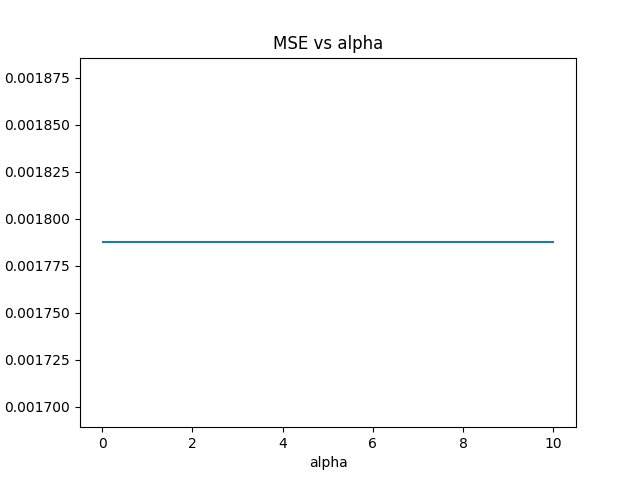

Text(0.5, 0, 'alpha')

In [26]:
plt.figure()
plt.plot(lasso_regression_hp_dict["alpha"], lasso_mse)
plt.title("MSE vs alpha")
plt.ylabel("MSE")
plt.xlabel("alpha")

In [18]:
ridge_mse = []
ridge_prediction_dictionary = {}
for alpha in ridge_regression_hp_dict["alpha"]:
    ridge = Ridge(alpha = alpha)
    model_name = "ridge_alpha={}".format(alpha)
    ridge_preds = roll_training(training_data_y,training_data_x, train_datelist, ridge,model_name)
    ridge_prediction_dictionary[alpha] = ridge_preds
    ### Compute MSE
    ## Extract common datelist
    common_dates = ridge_preds["date"].tolist()
    ridge_mse.append(mean_squared_error(training_data_y[training_data_y.index.isin(common_dates)],
                                        ridge_preds[model_name]))

<IPython.core.display.Javascript object>


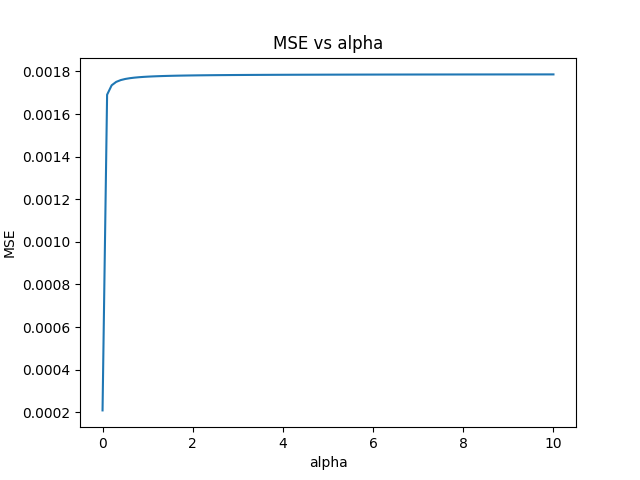

Text(0.5, 0, 'alpha')

In [27]:
plt.figure()
plt.plot(ridge_regression_hp_dict["alpha"], ridge_mse)
plt.title("MSE vs alpha")
plt.ylabel("MSE")
plt.xlabel("alpha")

In [29]:
## Checking plain regression
reg = LinearRegression()
linear_preds = roll_training(training_data_y,training_data_x, train_datelist, reg,"plain_regression")
print(mean_squared_error(training_data_y[training_data_y.index.isin(common_dates)],
                                        linear_preds['plain_regression']))

1.1899142683670332e-05


In [32]:
### Check results on overall data as well
lasso_mse = []
lasso_prediction_dictionary = {}
for alpha in lasso_regression_hp_dict["alpha"]:
    lasso = Lasso(alpha = alpha)
    model_name = "lasso_alpha={}".format(alpha)
    lasso_preds = roll_training(full_data_y,full_data_x, datelist, lasso,model_name)
    lasso_prediction_dictionary[alpha] = lasso_preds
    ### Compute MSE
    ## Extract common datelist
    common_dates = lasso_preds["date"].tolist()
    lasso_mse.append(mean_squared_error(full_data_y[full_data_y.index.isin(common_dates)],
                                        lasso_preds[model_name]))

<IPython.core.display.Javascript object>


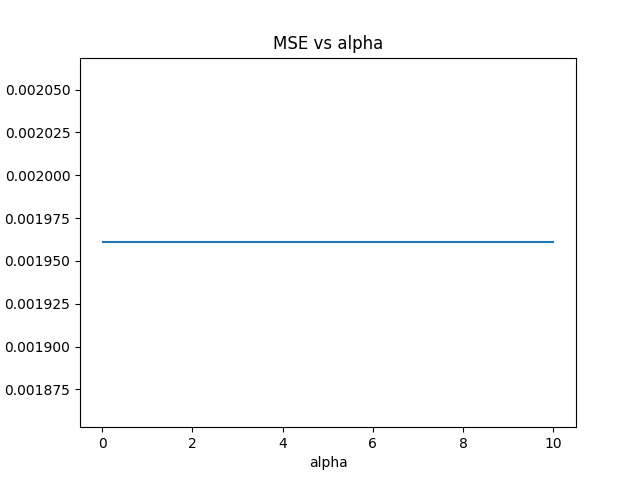

Text(0.5, 0, 'alpha')

In [33]:
plt.figure()
plt.plot(lasso_regression_hp_dict["alpha"], lasso_mse)
plt.title("MSE vs alpha")
plt.ylabel("MSE")
plt.xlabel("alpha")

In [34]:
ridge_mse = []
ridge_prediction_dictionary = {}
for alpha in ridge_regression_hp_dict["alpha"]:
    ridge = Ridge(alpha = alpha)
    model_name = "ridge_alpha={}".format(alpha)
    ridge_preds = roll_training(full_data_y,full_data_x, datelist, ridge,model_name)
    ridge_prediction_dictionary[alpha] = ridge_preds
    ### Compute MSE
    ## Extract common datelist
    common_dates = ridge_preds["date"].tolist()
    ridge_mse.append(mean_squared_error(full_data_y[full_data_y.index.isin(common_dates)],
                                        ridge_preds[model_name]))

<IPython.core.display.Javascript object>


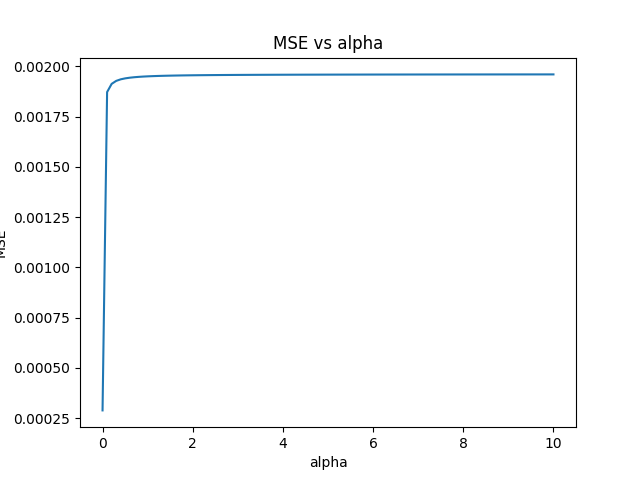

Text(0.5, 0, 'alpha')

In [35]:
plt.figure()
plt.plot(ridge_regression_hp_dict["alpha"], ridge_mse)
plt.title("MSE vs alpha")
plt.ylabel("MSE")
plt.xlabel("alpha")

In [37]:
## Checking plain regression
reg = LinearRegression()
linear_preds = roll_training(full_data_y,full_data_x, datelist, reg,"plain_regression")
print(mean_squared_error(full_data_y[full_data_y.index.isin(common_dates)],
                                        linear_preds['plain_regression']))

2.696318825210262e-05


## Code for GRID search scheme

In [116]:
random_forest_hp_dict = {
    "n_estimators" : [50,100,150,200],
    "max_depth":[2,3,5,7,10],
    "min_samples_leaf":[1,3,5,10],
}

random_forest_hp_dict_mini = {
    "n_estimators" : [25,50],
    "max_depth":[2,3],
    "min_samples_leaf":[1,3]
}

elastic_net_hp_dict = {
    "alpha" : [0.1, 0.2, 0.5, 0.7,1, 3, 10],
    "l1_ratio" : [0.1,0.3, 0.7,1]
}

xgboost_hp_dict = {
    "n_estimators" : [50,100,150,200],
    "max_depth":[2,3,5,7,10],
    "min_samples_leaf":[1,3,5,10],
}

In [43]:
import itertools

In [44]:
def generate_hyperparameter_grid(hp_space):

    keys, values = zip(*hp_space.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    return experiments

### Return top k predictions for a model class

In [45]:
mega_model_name = {}

In [60]:
def model_name_mappers(hp_space, base_model):
    model_name_mapper1 = {}
    model_name_mapper2 = {}
    for i in range(len(hp_space)):
        model_name_mapper1[base_model + "_" + str(i)] = str(hp_space[i])
        model_name_mapper2[str(hp_space[i])] = base_model + "_" + str(i)
    return model_name_mapper1, model_name_mapper2

In [97]:
def get_grid_model_results(base_mod, hp_space, model_name, Y, X, datelist):
    model_names_mapping1, model_names_mapping2 = model_name_mappers(hp_space, model_name)
    model_prediction_dictionary = {}
    prog_i = 0
    total_len = len(hp_space)
    for model_config in hp_space:
        if prog_i%10 == 0:
            print("% complete  = {}%".format(prog_i*100/total_len))
        model = base_mod(**model_config)
        pred_model_name = model_names_mapping2[str(model_config)]
        model_prediction = roll_training(Y,X, datelist, model , pred_model_name)
        model_prediction_dictionary[pred_model_name] = model_prediction
        prog_i+=1
        
    return (model_names_mapping1, model_names_mapping2, model_prediction_dictionary)

In [114]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [99]:
a,b,c = get_grid_model_results(RandomForestRegressor, generate_hyperparameter_grid(random_forest_hp_dict_mini),
                              "RF", training_data_y, training_data_x, train_datelist)

% complete  = 0.0%


In [101]:
def model_performance_metrics(metric, pred_dict, actual_y):
    score_dict = {}
    for key, values in pred_dict.items():
        common_datelist = values["date"].tolist()
        score_dict[key] = metric(actual_y[actual_y.index.isin(common_datelist)], values[values.columns[-1]])
    return score_dict

In [102]:
model_performance_metrics(mean_squared_error, c, training_data_y)

{'RF_0': 0.0007439622127698396,
 'RF_1': 0.0007073441673247343,
 'RF_2': 0.0005392957118997,
 'RF_3': 0.0005595725032582886,
 'RF_4': 0.0006906089441320092,
 'RF_5': 0.0007050992006734577,
 'RF_6': 0.0005275033804397668,
 'RF_7': 0.000559581318780008}

In [103]:
import heapq

In [104]:
def top_k_predictions(k, performance_metrics):

    k_keys_sorted = heapq.nsmallest(k, performance_metrics, key=performance_metrics.get)
    return k_keys_sorted

In [108]:
rf_names_1, rf_names_2, rf_model_predictions = get_grid_model_results(RandomForestRegressor, generate_hyperparameter_grid(random_forest_hp_dict),
                              "RF", full_data_y, full_data_y, datelist)

% complete  = 0.0%
% complete  = 12.5%
% complete  = 25.0%
% complete  = 37.5%
% complete  = 50.0%
% complete  = 62.5%
% complete  = 75.0%
% complete  = 87.5%


In [112]:
rf_model_performance = model_performance_metrics(mean_squared_error, rf_model_predictions, full_data_y)

In [113]:
top_k_predictions(3,rf_model_performance)

['RF_4', 'RF_13', 'RF_54']

In [117]:
xg_names_1, xg_names_2, xg_model_predictions = get_grid_model_results(GradientBoostingRegressor, generate_hyperparameter_grid(xgboost_hp_dict),
                              "XG", full_data_y, full_data_y, datelist)

% complete  = 0.0%
% complete  = 12.5%
% complete  = 25.0%
% complete  = 37.5%
% complete  = 50.0%
% complete  = 62.5%
% complete  = 75.0%
% complete  = 87.5%


In [118]:
xg_model_performance = model_performance_metrics(mean_squared_error, xg_model_predictions, full_data_y)

In [120]:
top_k_predictions(3,xg_model_performance)

['XG_60', 'XG_61', 'XG_62']

In [121]:
en_names_1, en_names_2, en_model_predictions = get_grid_model_results(ElasticNet, generate_hyperparameter_grid(elastic_net_hp_dict),
                              "EN", full_data_y, full_data_y, datelist)

% complete  = 0.0%
% complete  = 35.714285714285715%
% complete  = 71.42857142857143%


In [122]:
en_model_performance = model_performance_metrics(mean_squared_error, en_model_predictions, full_data_y)

In [123]:
top_k_predictions(3,en_model_performance)

['EN_0', 'EN_4', 'EN_1']

In [125]:
lasso_names_1, lasso_names_2, lasso_model_predictions = get_grid_model_results(Lasso, generate_hyperparameter_grid(lasso_regression_hp_dict),
                              "lasso", full_data_y, full_data_y, datelist)

% complete  = 0.0%
% complete  = 10.0%
% complete  = 20.0%
% complete  = 30.0%
% complete  = 40.0%
% complete  = 50.0%
% complete  = 60.0%
% complete  = 70.0%
% complete  = 80.0%
% complete  = 90.0%


In [126]:
lasso_model_performance = model_performance_metrics(mean_squared_error, lasso_model_predictions, full_data_y)
top_k_predictions(3,lasso_model_performance)

['lasso_0', 'lasso_1', 'lasso_2']

In [127]:
ridge_names_1, ridge_names_2, ridge_model_predictions = get_grid_model_results(Ridge, generate_hyperparameter_grid(ridge_regression_hp_dict),
                              "ridge", full_data_y, full_data_y, datelist)

% complete  = 0.0%
% complete  = 10.0%
% complete  = 20.0%
% complete  = 30.0%
% complete  = 40.0%
% complete  = 50.0%
% complete  = 60.0%
% complete  = 70.0%
% complete  = 80.0%
% complete  = 90.0%


In [128]:
ridge_model_performance = model_performance_metrics(mean_squared_error, ridge_model_predictions, full_data_y)
top_k_predictions(3, ridge_model_performance)

['ridge_0', 'ridge_1', 'ridge_2']

In [129]:
best_model_output = []

best_rf_pred = top_k_predictions(3,rf_model_performance)
best_xg_pred = top_k_predictions(3,xg_model_performance)
best_en_pred = top_k_predictions(3,en_model_performance)
best_lasso_pred = top_k_predictions(3,lasso_model_performance)
best_ridge_pred = top_k_predictions(3,ridge_model_performance)

In [133]:
def return_dict_keys_df(dictionary, keys):
    inil = []
    for key in keys:
        temp_df = dictionary[key]
        inil.append(temp_df[temp_df.columns[-1]])
    return pd.concat(inil, axis=1)

In [135]:
best_rf_model = return_dict_keys_df(rf_model_predictions, best_rf_pred)
best_xg_model = return_dict_keys_df(xg_model_predictions, best_xg_pred)
best_en_model = return_dict_keys_df(en_model_predictions, best_en_pred)
best_lasso_model = return_dict_keys_df(lasso_model_predictions, best_lasso_pred)
best_ridge_model = return_dict_keys_df(ridge_model_predictions, best_ridge_pred)

In [141]:
for cols in best_ridge_model.columns:
    best_ridge_model[cols] = best_ridge_model[cols].apply(lambda x:x[0])

In [143]:
mega_df = pd.concat([best_rf_model,best_xg_model,best_en_model,best_lasso_model,best_ridge_model ], axis=1)

In [146]:
mega_df["date"] = common_dates

In [148]:
mega_df.set_index("date",inplace=True)

<IPython.core.display.Javascript object>


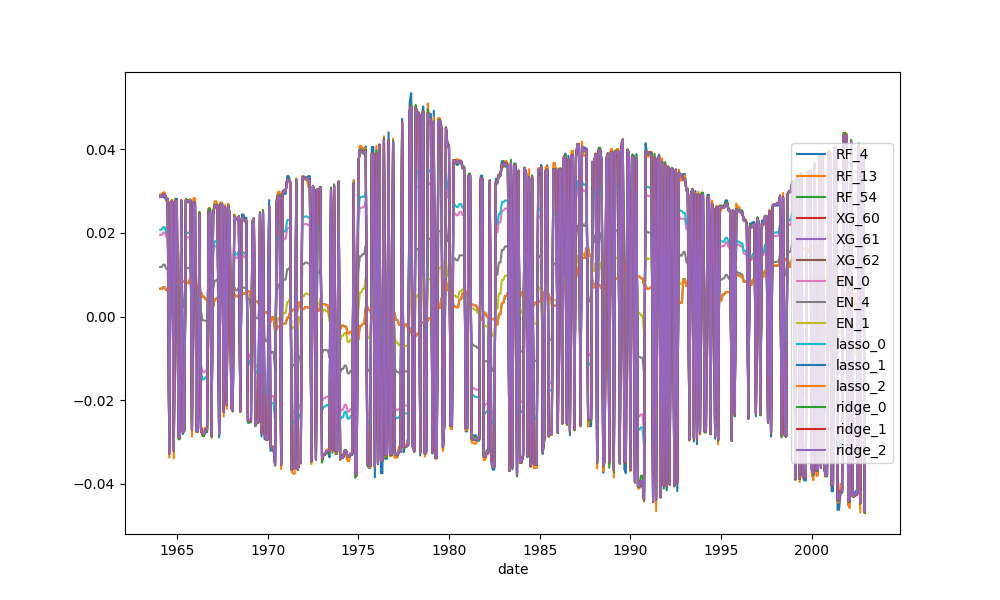

<AxesSubplot:xlabel='date'>

In [154]:
mega_df.plot(figsize=(10,6))

<IPython.core.display.Javascript object>


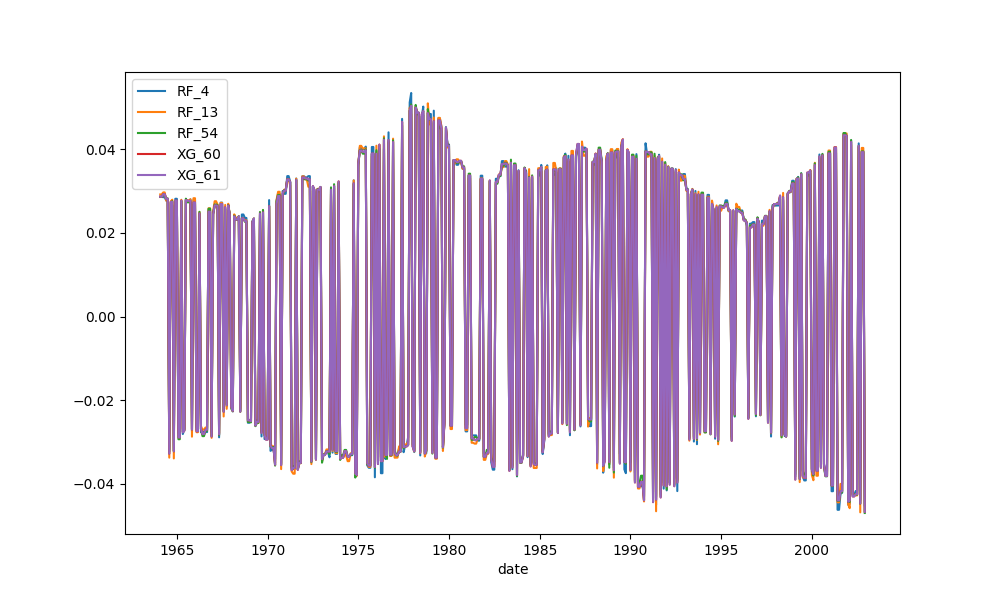

<AxesSubplot:xlabel='date'>

In [155]:
## Break into grps of 5 and plot
mega_df[mega_df.columns.tolist()[0:5]].plot(figsize=(10,6))

<IPython.core.display.Javascript object>


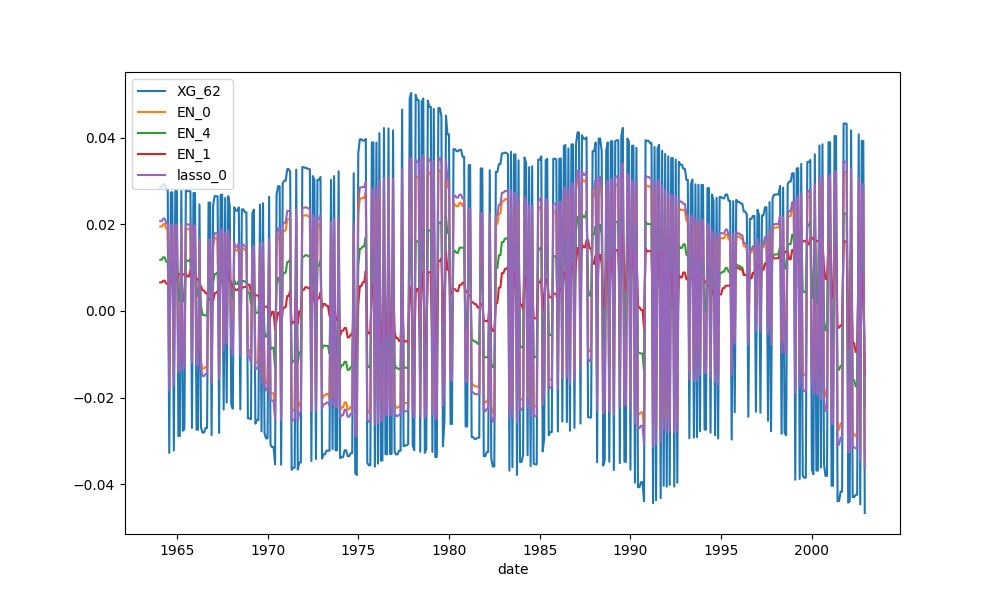

<AxesSubplot:xlabel='date'>

In [156]:
mega_df[mega_df.columns.tolist()[5:10]].plot(figsize=(10,6))

<IPython.core.display.Javascript object>


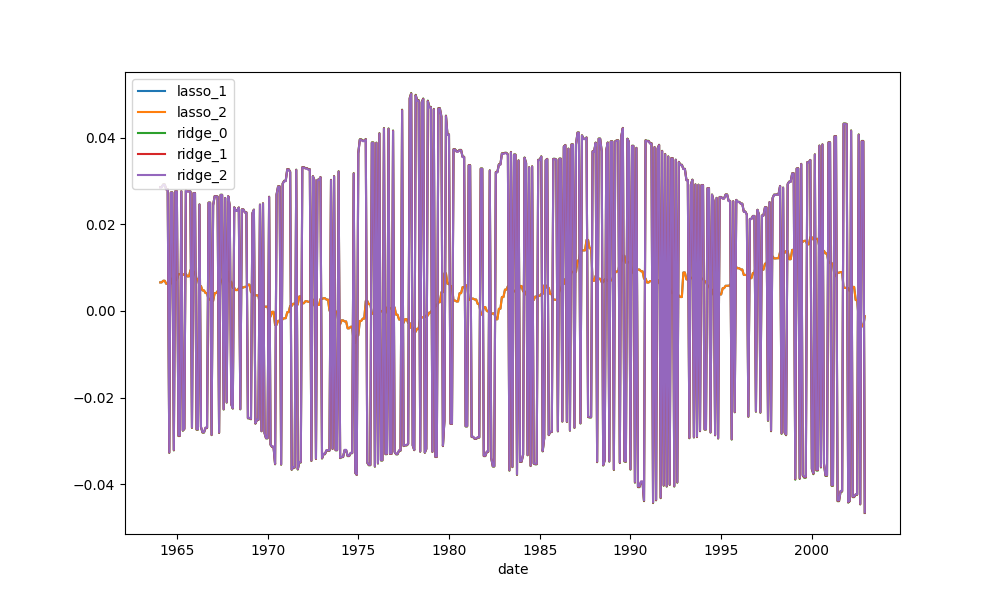

<AxesSubplot:xlabel='date'>

In [157]:
mega_df[mega_df.columns.tolist()[10:]].plot(figsize=(10,6))

### Step 4: Check trading strategy

In [158]:
## Create trading strategy
def trading_strategy(yactual, ypred):
    # strat 1: Long on market
    strat1_ret = yactual
    # strat 2: Long if pred positive, short if pred negative
    bool_temp = [1 if x > 0 else -1 for x in ypred.values]
    strat2_ret = yactual*bool_temp
    # strat 3: 2x long if pred positive, 0 if pred negative
    bool_temp = [2 if x > 0 else 0 for x in ypred.values]
    strat3_ret = yactual*bool_temp
    # strat 4: 1x long if pred positive, 0 if pred negative
    bool_temp = [1 if x > 0 else 0 for x in ypred.values]
    strat4_ret = yactual*bool_temp
    
    ret_df = pd.DataFrame([strat1_ret, strat2_ret, strat3_ret, strat4_ret]).T
    ret_df.columns = ["Strategy 1", "Strategy 2", "Strategy 3", "Strategy 4"]
    
    # Cumulative return
    cum_ret = ret_df + 1
    cum_ret = cum_ret.cumprod()
    return ret_df, cum_ret

In [164]:
full_data_y[full_data_y.index.isin(common_dates)]

premium
date                
1964-02-01  0.009767
1964-03-01  0.014563
1964-04-01  0.005654
1964-05-01  0.011331
1964-06-01  0.015892
...              ...
2002-08-01  0.004933
2002-09-01 -0.109976
2002-10-01  0.086660
2002-11-01  0.057373
2002-12-01 -0.060002

[467 rows x 1 columns]

RF_4
Plotting strategies for model = RF_4


<IPython.core.display.Javascript object>


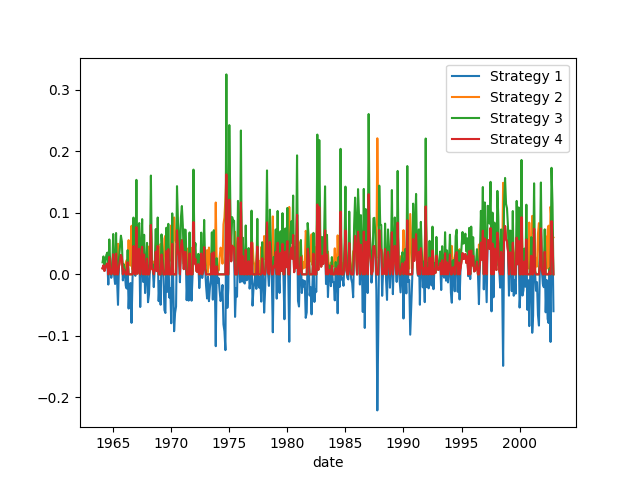

<IPython.core.display.Javascript object>


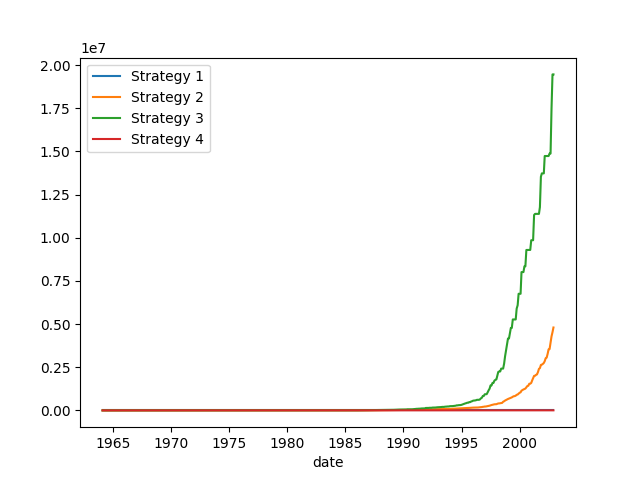

RF_13
Plotting strategies for model = RF_13


<IPython.core.display.Javascript object>


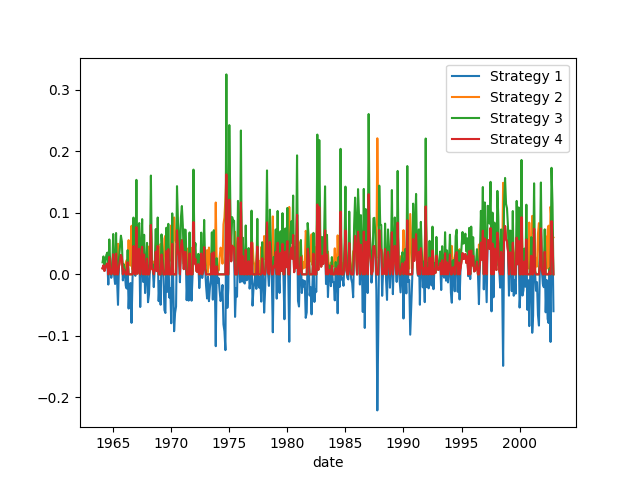

<IPython.core.display.Javascript object>


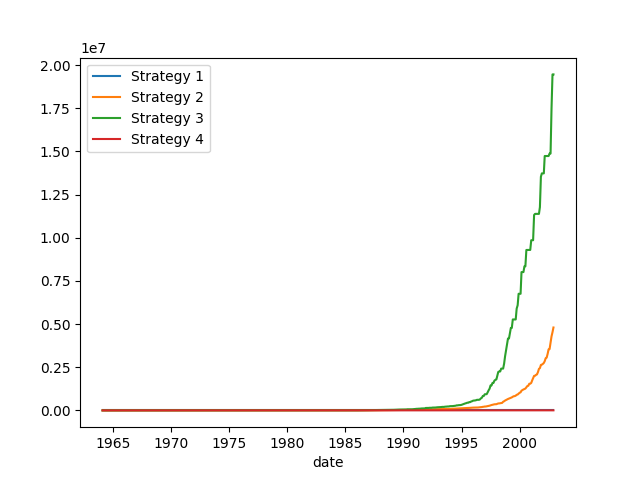

RF_54
Plotting strategies for model = RF_54


<IPython.core.display.Javascript object>


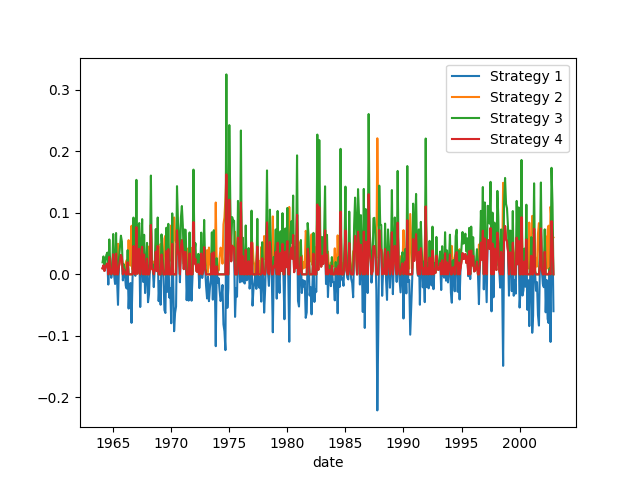

<IPython.core.display.Javascript object>


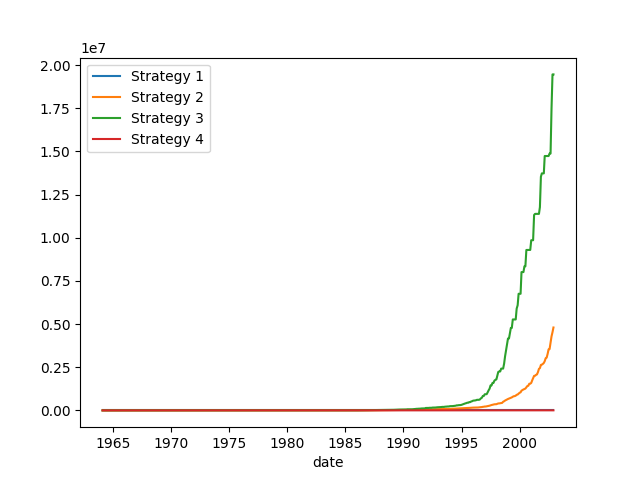

XG_60
Plotting strategies for model = XG_60


<IPython.core.display.Javascript object>


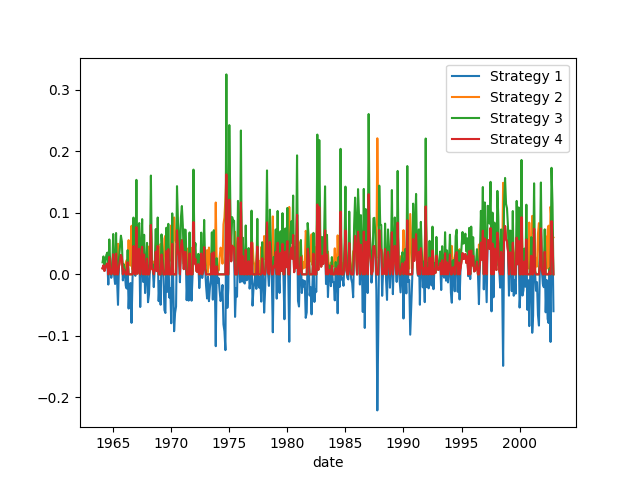

<IPython.core.display.Javascript object>


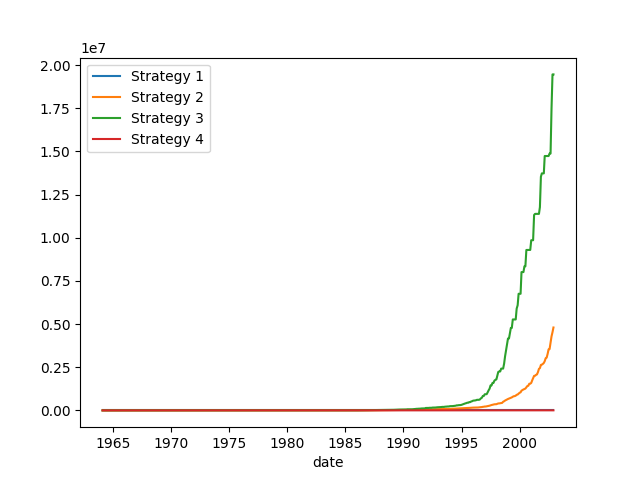

XG_61
Plotting strategies for model = XG_61


<IPython.core.display.Javascript object>


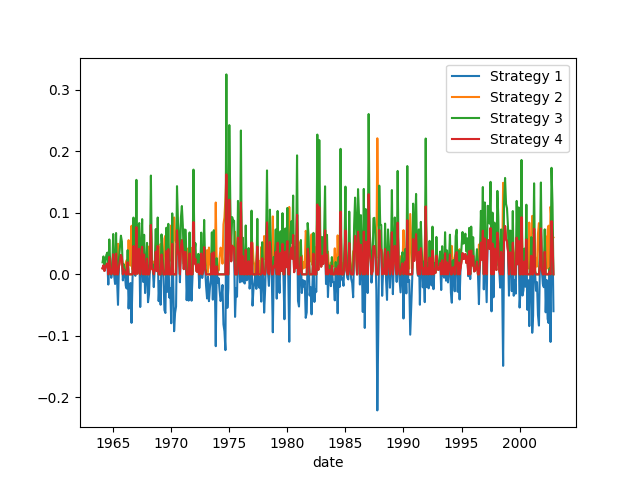

<IPython.core.display.Javascript object>


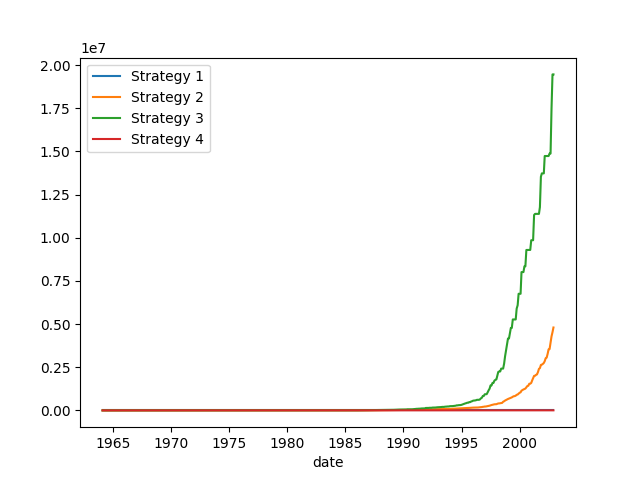

XG_62
Plotting strategies for model = XG_62


<IPython.core.display.Javascript object>


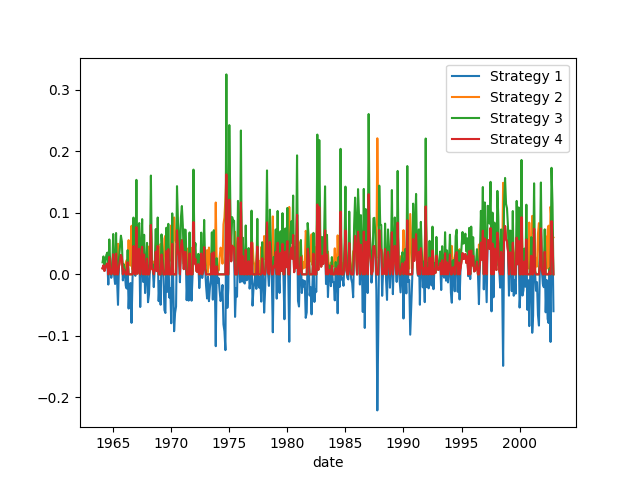

<IPython.core.display.Javascript object>


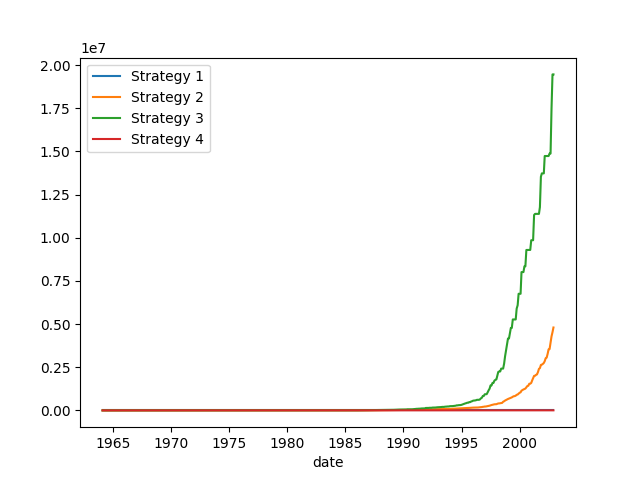

EN_0
Plotting strategies for model = EN_0


<IPython.core.display.Javascript object>


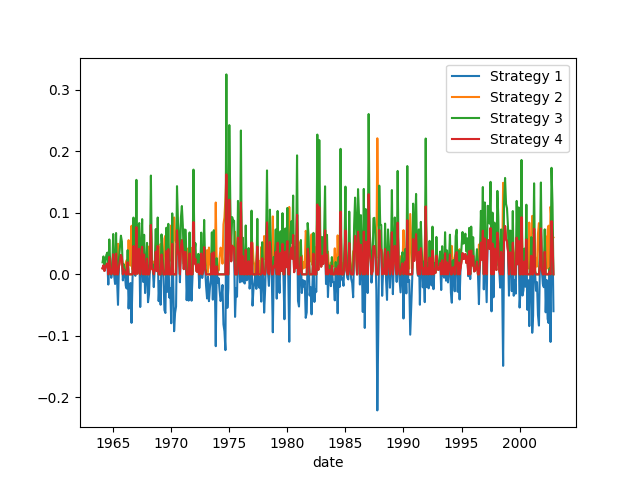

<IPython.core.display.Javascript object>


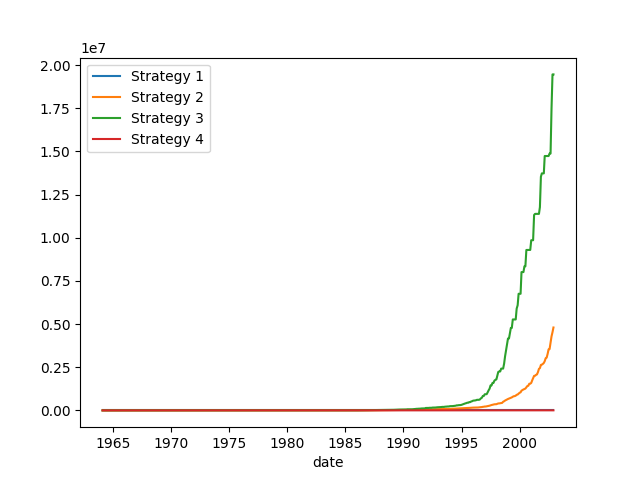

EN_4
Plotting strategies for model = EN_4


<IPython.core.display.Javascript object>


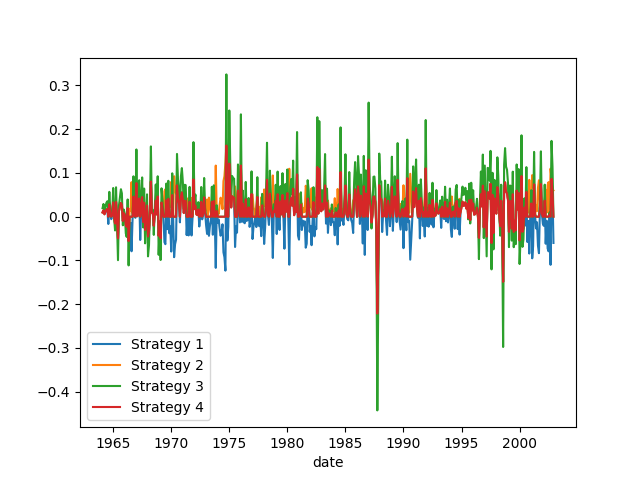

<IPython.core.display.Javascript object>


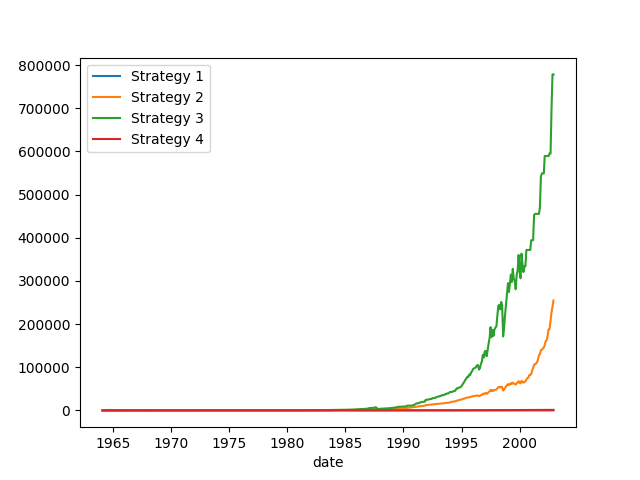

EN_1
Plotting strategies for model = EN_1


<IPython.core.display.Javascript object>


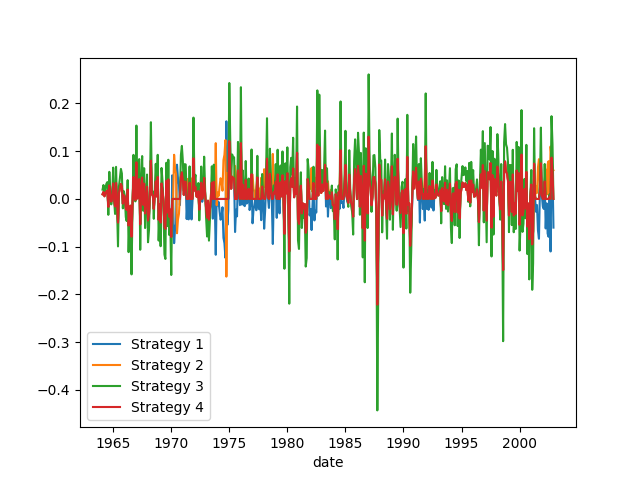

<IPython.core.display.Javascript object>


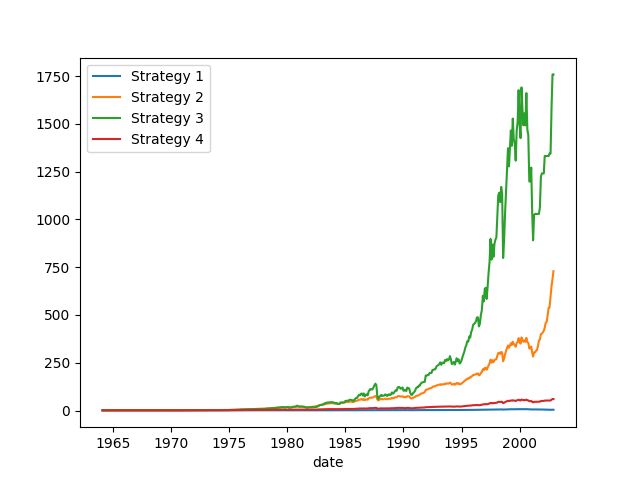

lasso_0
Plotting strategies for model = lasso_0


<IPython.core.display.Javascript object>


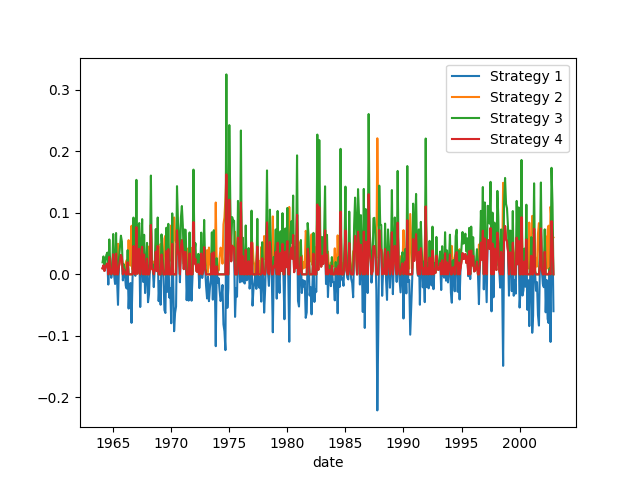

<IPython.core.display.Javascript object>


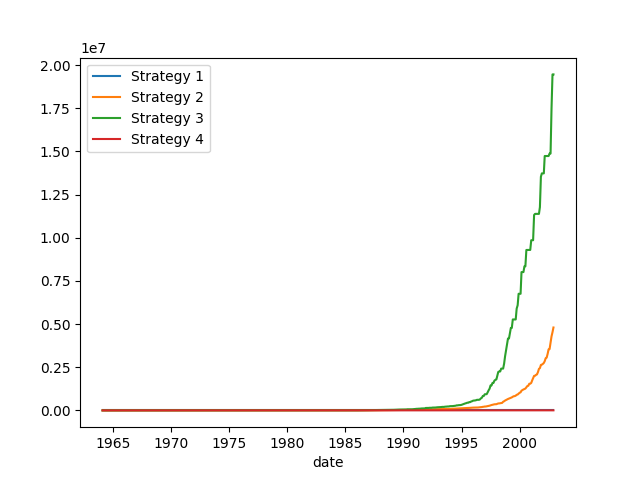

lasso_1
Plotting strategies for model = lasso_1


<IPython.core.display.Javascript object>


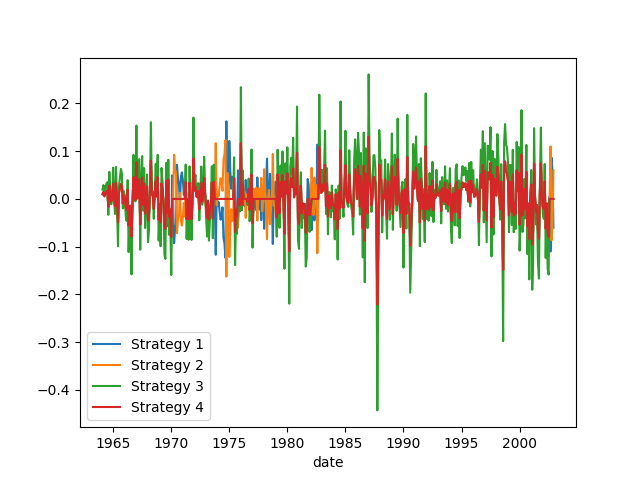

<IPython.core.display.Javascript object>


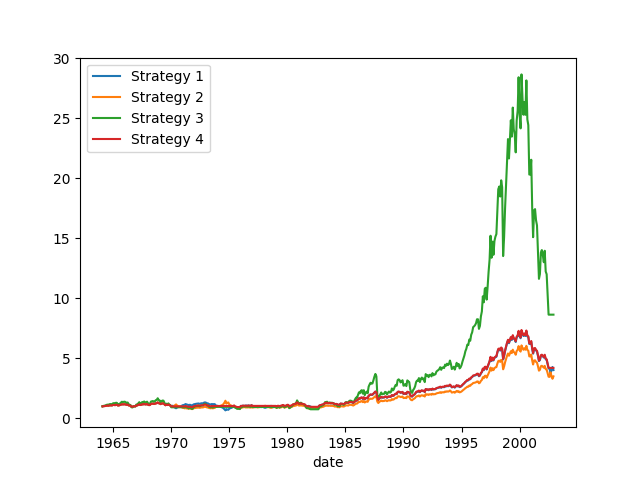

lasso_2
Plotting strategies for model = lasso_2


<IPython.core.display.Javascript object>


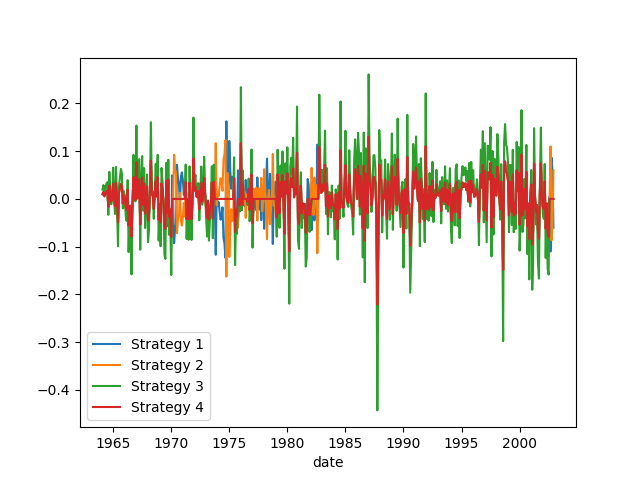

<IPython.core.display.Javascript object>


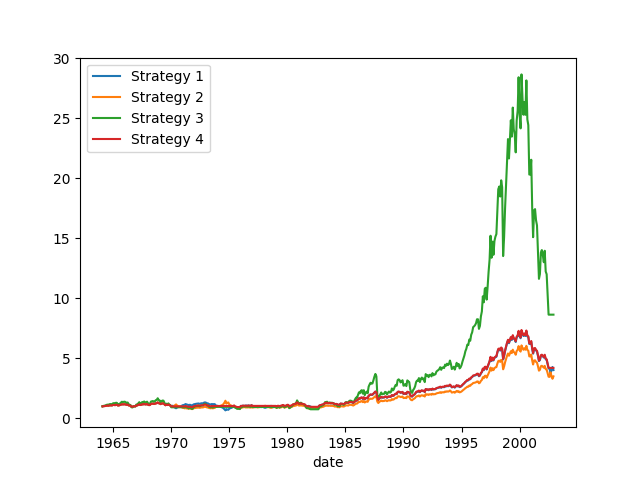

ridge_0
Plotting strategies for model = ridge_0


<IPython.core.display.Javascript object>


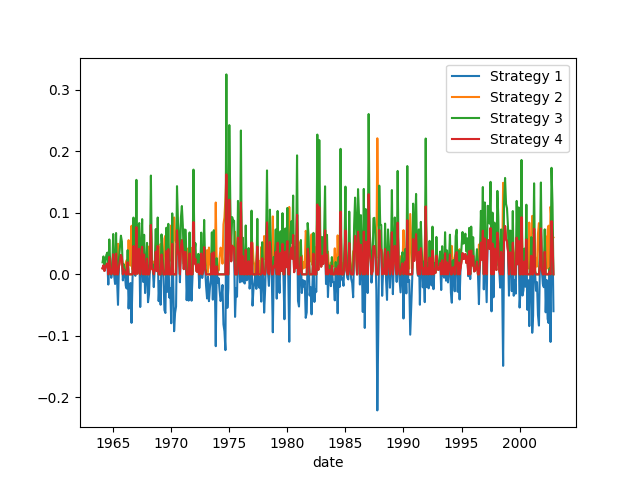

<IPython.core.display.Javascript object>


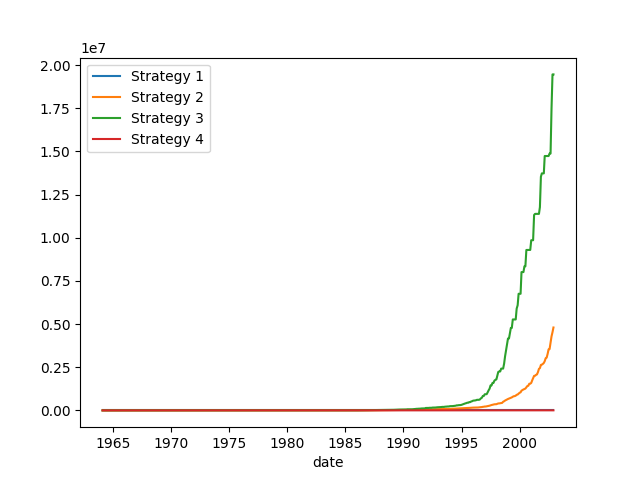

ridge_1
Plotting strategies for model = ridge_1


<IPython.core.display.Javascript object>


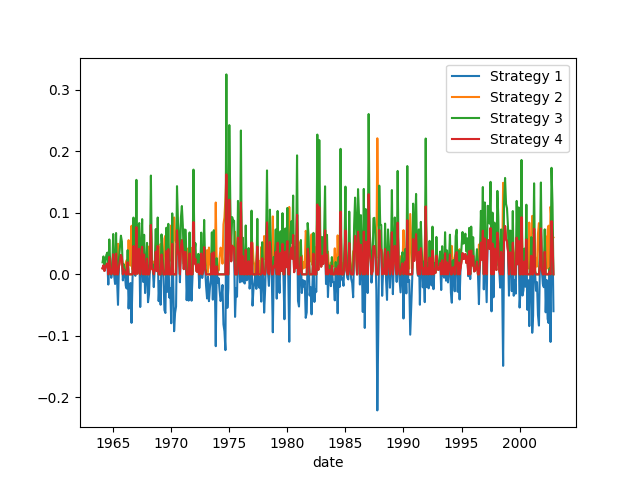

<IPython.core.display.Javascript object>


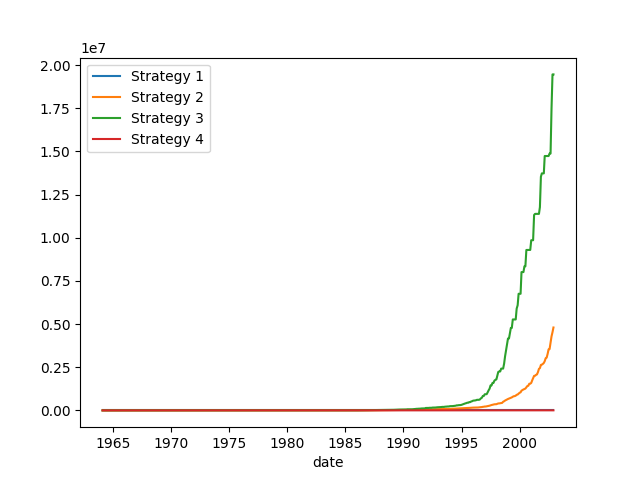

ridge_2
Plotting strategies for model = ridge_2


<IPython.core.display.Javascript object>


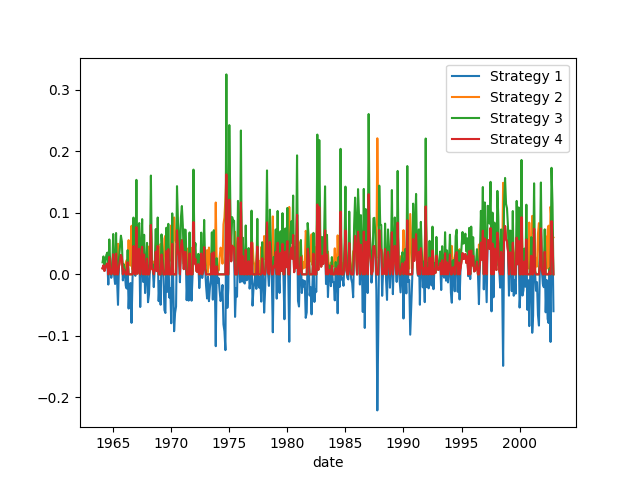

<IPython.core.display.Javascript object>


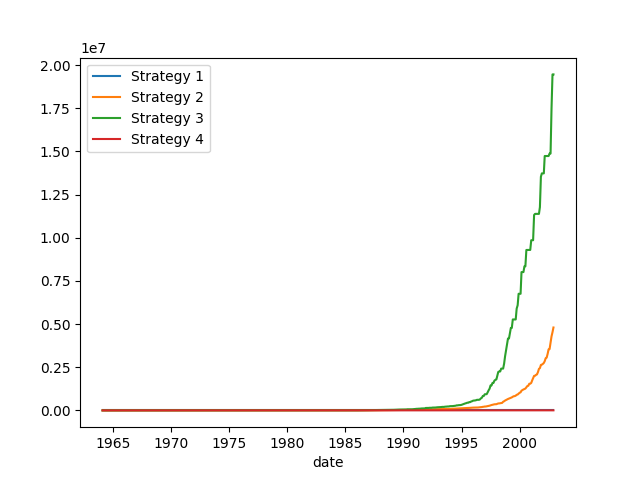

In [167]:
## Check trading strategy for every model
for col in mega_df.columns:
    ypred = mega_df[col]
    print(col)
    ret_df, cum_ret_df = trading_strategy(full_data_y[full_data_y.index.isin(common_dates)]["premium"], ypred)
    print("Plotting strategies for model = {}".format(col))
    ret_df.plot()
    cum_ret_df.plot()

## Step 5: Train simple OLS, Mean, Median on predictions

In [173]:
base_models = mega_df.columns.tolist()
mega_df["mean_pred"] = mega_df[base_models].mean(axis=1)
mega_df["median_pred"] = mega_df[base_models].median(axis=1)

In [169]:
yactual = full_data_y[full_data_y.index.isin(common_dates)]["premium"]

In [170]:
reg = LinearRegression()
reg.fit(mega_df[base_models], yactual)

LinearRegression()

In [171]:
mega_df["ensemble_ols"] = reg.predict(mega_df[base_models])

<IPython.core.display.Javascript object>


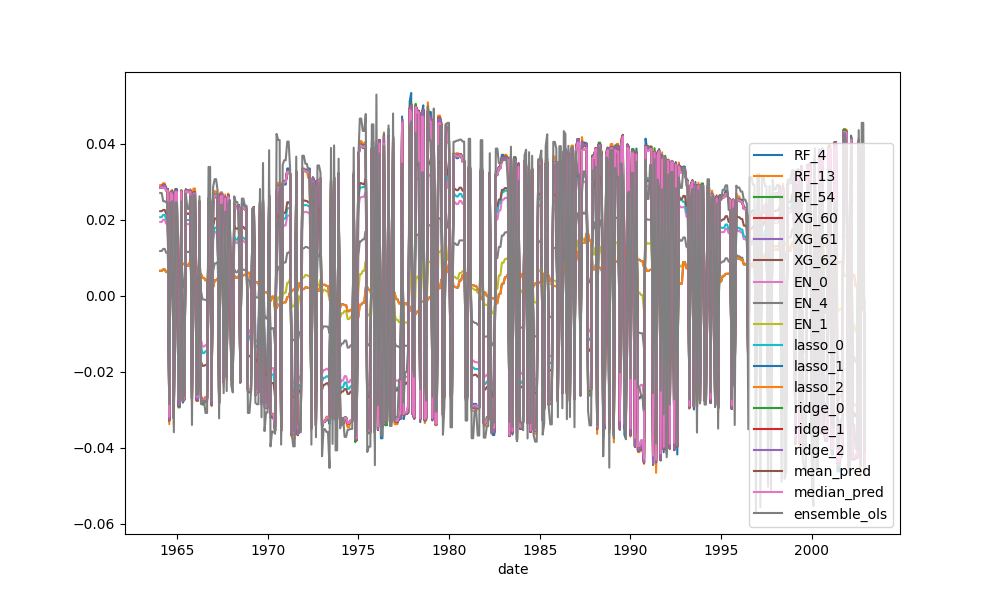

<AxesSubplot:xlabel='date'>

In [176]:
mega_df.plot(figsize=(10,6))

## Plot strategy for every model


### Strategy 1

<IPython.core.display.Javascript object>


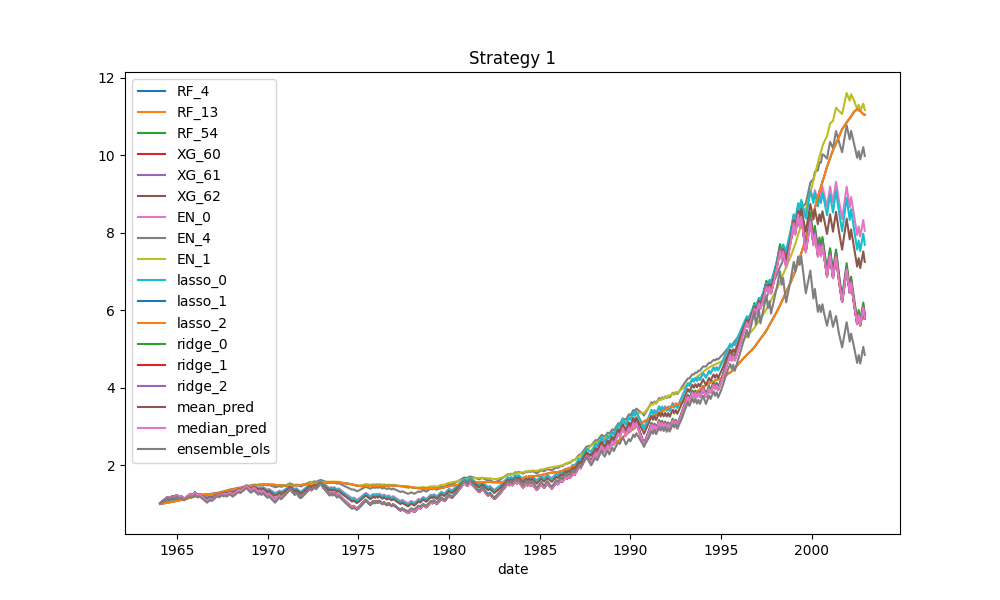

Text(0.5, 1.0, 'Strategy 1')

In [199]:
(mega_df + 1).cumprod().plot(legend=True, figsize=(10,6))
plt.title("Strategy 1")

In [207]:
temp_list = []
for col in mega_df.columns:
    bool_temp = [1 if x > 0 else -1 for x in mega_df[col].values]
    strat2_ret = yactual*bool_temp
    temp_list.append(strat2_ret)
strat2_df = pd.concat(temp_list,axis=1)
strat2_df.columns = base_models

<IPython.core.display.Javascript object>


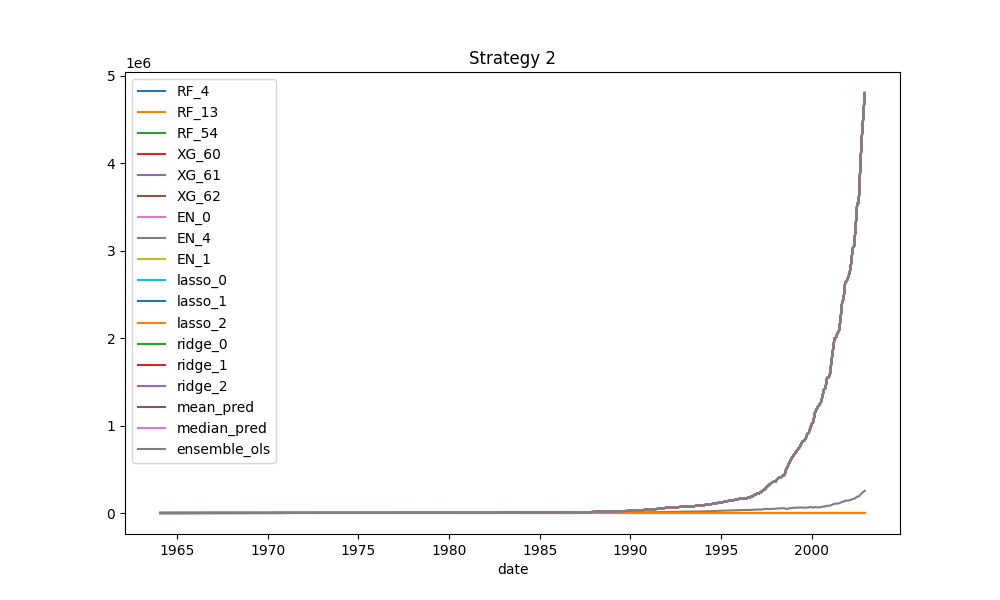

Text(0.5, 1.0, 'Strategy 2')

In [209]:
(strat2_df + 1).cumprod().plot(legend=True, figsize=(10,6))
plt.title("Strategy 2")

<IPython.core.display.Javascript object>


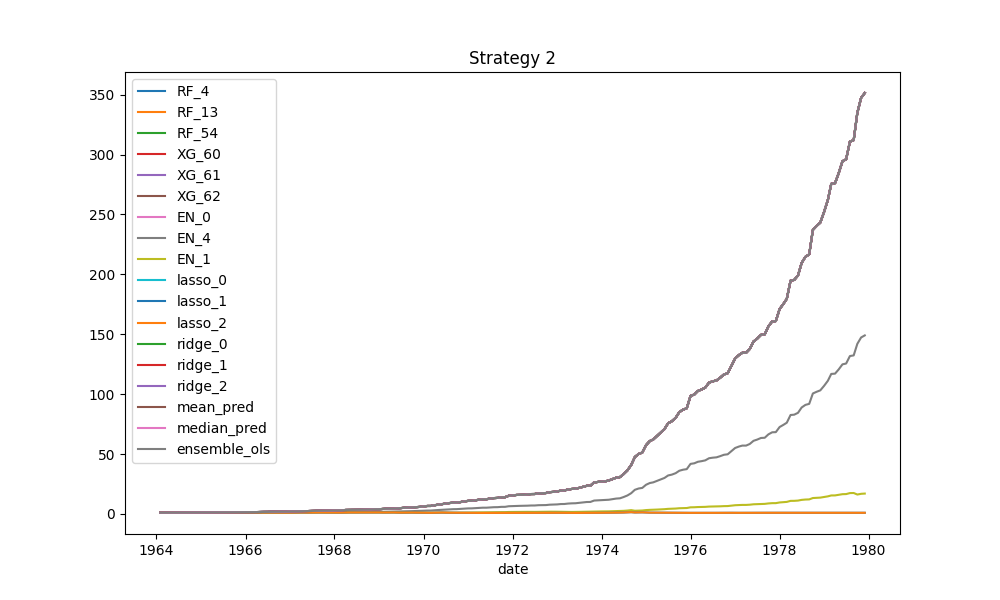

Text(0.5, 1.0, 'Strategy 2')

In [213]:
x = (strat2_df + 1).cumprod()
x[x.index < datetime(1980,1,1).date()].plot(legend=True, figsize=(10,6))
plt.title("Strategy 2")

In [228]:
temp_list = []
for col in mega_df.columns:
    bool_temp = [2 if x > 0 else 0 for x in mega_df[col].values]
    strat3_ret = yactual*bool_temp
    temp_list.append(strat3_ret)
strat3_df = pd.concat(temp_list,axis=1)
strat3_df.columns = base_models

<IPython.core.display.Javascript object>


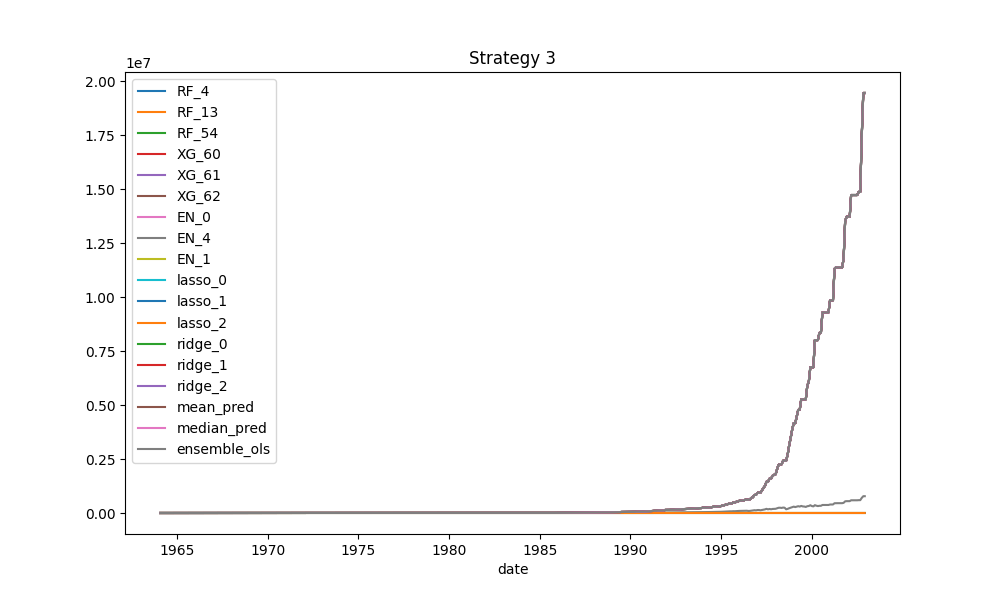

Text(0.5, 1.0, 'Strategy 3')

In [229]:
x = (strat3_df + 1).cumprod().plot(legend=True, figsize=(10,6))
plt.title("Strategy 3")

<IPython.core.display.Javascript object>


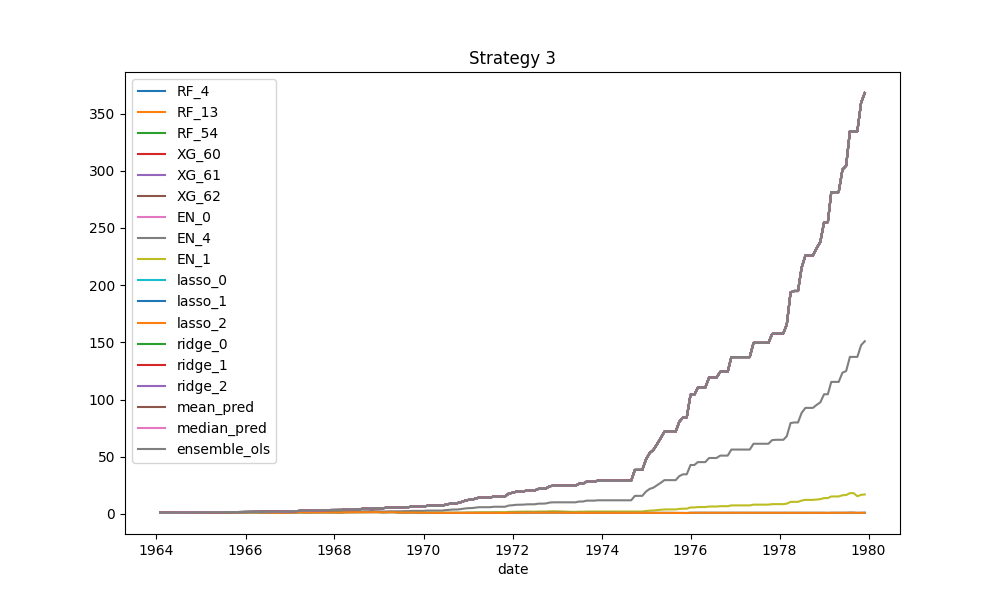

Text(0.5, 1.0, 'Strategy 3')

In [230]:
x = (strat3_df + 1).cumprod()
x[x.index < datetime(1980,1,1).date()].plot(legend=True, figsize=(10,6))
plt.title("Strategy 3")

In [231]:
temp_list = []
for col in mega_df.columns:
    bool_temp = [1 if x > 0 else 0 for x in mega_df[col].values]
    strat4_ret = yactual*bool_temp
    temp_list.append(strat4_ret)
strat4_df = pd.concat(temp_list,axis=1)
strat4_df.columns = base_models

<IPython.core.display.Javascript object>


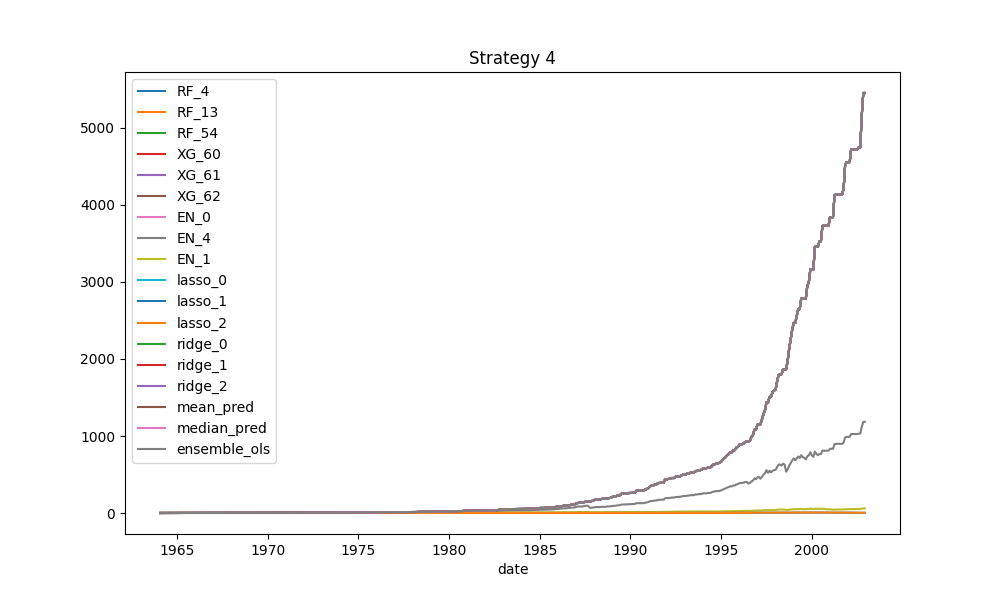

Text(0.5, 1.0, 'Strategy 4')

In [232]:
x = (strat4_df + 1).cumprod().plot(legend=True, figsize=(10,6))
plt.title("Strategy 4")

<IPython.core.display.Javascript object>


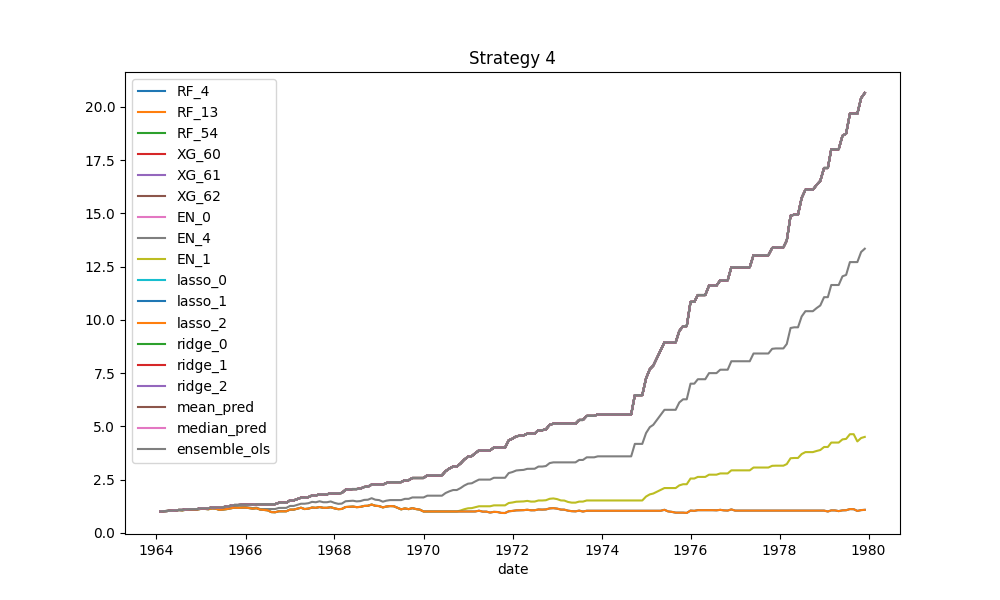

Text(0.5, 1.0, 'Strategy 4')

In [233]:
x = (strat4_df + 1).cumprod()
x[x.index < datetime(1980,1,1).date()].plot(legend=True, figsize=(10,6))
plt.title("Strategy 4")